In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
import squarify
from scipy.stats.stats import pearsonr
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [2]:
df_ = pd.read_csv(r'D:\NMIMS\research treatise\online_retail_final.csv',encoding="unicode_escape", parse_dates=['InvoiceDate'],dayfirst=True)

In [16]:
df = df_.copy()

In [18]:
pd.to_datetime(df_['InvoiceDate'].max())-pd.to_datetime(df_['InvoiceDate'].min())

Timedelta('373 days 12:16:00')

In [19]:
pd.to_datetime(df123['InvoiceDate'].min())

NameError: name 'df123' is not defined

In [20]:
df = df_.copy()
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [21]:
df[["Quantity","Price"]].describe().T

count       mean         std       min   25%  50%    75%  \
Quantity  525461.0  10.337667  107.424110  -9600.00  1.00  3.0  10.00   
Price     525461.0   4.688834  146.126914 -53594.36  1.25  2.1   4.21   

               max  
Quantity  19152.00  
Price     25111.09

In [22]:
df.isnull().sum().any() #We have missing observations in our data set.

True

In [23]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [24]:
df.dropna(inplace=True)
df.isnull().sum() #We removed our missing observations

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [25]:
#We are only interested in values greater than zero in the Quantity and Price fields.
#We also do not consider canceled transactions.
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[(df['Quantity'] > 0)]
df = df[(df['Price'] > 0)]


In [26]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [27]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [28]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS      12.0   
1  489434    79323P                   PINK CHERRY LIGHTS      12.0   
2  489434    79323W                  WHITE CHERRY LIGHTS      12.0   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE       48.0   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX      24.0   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom       100.8  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom        30.0

In [29]:
today_date = pd.to_datetime(df['InvoiceDate'].max()) + pd.DateOffset(days=1)

In [30]:
pd.to_datetime(df['InvoiceDate'].max())

Timestamp('2010-12-09 20:01:00')

In [31]:
pd.to_datetime(df['InvoiceDate'].min())

Timestamp('2009-12-01 07:45:00')

In [32]:
pd.to_datetime(df['InvoiceDate'].max())-pd.to_datetime(df['InvoiceDate'].min())

Timedelta('373 days 12:16:00')

In [33]:
# Calculate customer specific Recency, Frequency and Monetary metrics with groupby, agg and lambda. 
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

# Change the names of the metrics you created to recency, frequency and monetary.
rfm.columns = ['recency', 'frequency', 'monetary']  


In [34]:
# Note 2: After creating the rfm dataframe, filter the dataset to "monetary>0"
rfm = rfm[(rfm['monetary'] > 0)]

In [35]:
rfm.head()

recency  frequency  monetary
Customer ID                              
12346.0          165         11    372.86
12347.0            3          2   1323.32
12348.0           74          1    222.16
12349.0           43          3   2295.02
12351.0           11          1    300.93

In [36]:
# Convert Recency, Frequency and Monetary metrics to scores between 1-5 with the help of qcut.
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5 , labels=[1,2,3,4,5])

In [37]:
rfm.sort_values('recency')['recency_score'].value_counts()

5    906
1    855
4    853
3    850
2    848
Name: recency_score, dtype: int64

In [38]:
rfm.sort_values('frequency')['frequency_score'].value_counts()

1    863
5    863
2    862
3    862
4    862
Name: frequency_score, dtype: int64

In [39]:
rfm.sort_values('monetary')['monetary_score'].value_counts()

1    863
5    863
2    862
3    862
4    862
Name: monetary_score, dtype: int64

In [40]:
# Express the value of 2 different variables as a single variable and save it as RFM_SCORE
rfm["RFM_Combination"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)+ rfm['monetary_score'].astype(str))

In [41]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)

In [42]:
rfm.head()

recency  frequency  monetary recency_score frequency_score  \
Customer ID                                                               
12346.0          165         11    372.86             2               5   
12347.0            3          2   1323.32             5               2   
12348.0           74          1    222.16             2               1   
12349.0           43          3   2295.02             3               3   
12351.0           11          1    300.93             5               1   

            monetary_score RFM_Combination              Segment  
Customer ID                                                      
12346.0                  2             252          Can't Loose  
12347.0                  4             524  Potential Loyalists  
12348.0                  1             211          Hibernating  
12349.0                  5             335       Need Attention  
12351.0                  2             512        New Customers

In [43]:
rfmStats = rfm[["Segment","recency", "frequency", "monetary"]].groupby("Segment").agg(["mean","median","count", "std"])
rfmStats.columns = rfmStats.columns.map('_'.join).str.strip('|')
rfmStats

recency_mean  recency_median  recency_count  recency_std  \
Segment                                                                         
About to Sleep          53.819242            53.0            343    10.286082   
At Risk                152.155483           131.0            611    69.938219   
Can't Loose            124.116883           109.0             77    49.924673   
Champions                7.119155             7.0            663     4.619934   
Hibernating            213.884729           213.0           1015    89.931661   
Loyal Customers         36.287062            31.0            742    16.072703   
Need Attention          53.265700            53.0            207     9.796073   
New Customers            8.580000             8.5             50     4.309884   
Potential Loyalists     18.793037            19.0            517     9.730960   
Promising               25.747126            25.0             87     6.035204   

                     frequency_mean  frequency_median  frequency_count  \
Segment                                                                  
About to Sleep             1.201166                 1              343   
At Risk                    3.073650                 3              611   
Can't Loose                9.116883                 7               77   
Champions                 12.553544                 8              663   
Hibernating                1.126108                 1             1015   
Loyal Customers            6.830189                 5              742   
Need Attention             2.449275                 2              207   
New Customers              1.000000                 1               50   
Potential Loyalists        2.017408                 2              517   
Promising                  1.000000                 1               87   

                     frequency_std  monetary_mean  monetary_median  \
Segment                                                              
About to Sleep            0.401458     435.429111          315.980   
At Risk                   1.089206    1089.292367          754.380   
Can't Loose               5.973569    3486.987532         2322.590   
Champions                17.320676    6570.387425         2500.540   
Hibernating               0.332135     363.962832          245.480   
Loyal Customers           4.397982    2672.967508         1810.195   
Need Attention            0.498626    1009.158865          723.950   
New Customers             0.000000     385.877800          258.825   
Potential Loyalists       0.697231     718.512853          522.670   
Promising                 0.000000     362.921954          263.380   

                     monetary_count  monetary_std  
Segment                                            
About to Sleep                  343    414.935039  
At Risk                         611   1084.131406  
Can't Loose                      77   3783.937115  
Champions                       663  20053.177717  
Hibernating                    1015    494.215191  
Loyal Customers                 742   2964.907852  
Need Attention                  207   1131.878641  
New Customers                    50    493.302697  
Potential Loyalists             517    797.329120  
Promising                        87    344.410059

In [44]:
rfm.sort_values('Segment')['Segment'].value_counts()

Hibernating            1015
Loyal Customers         742
Champions               663
At Risk                 611
Potential Loyalists     517
About to Sleep          343
Need Attention          207
Promising                87
Can't Loose              77
New Customers            50
Name: Segment, dtype: int64

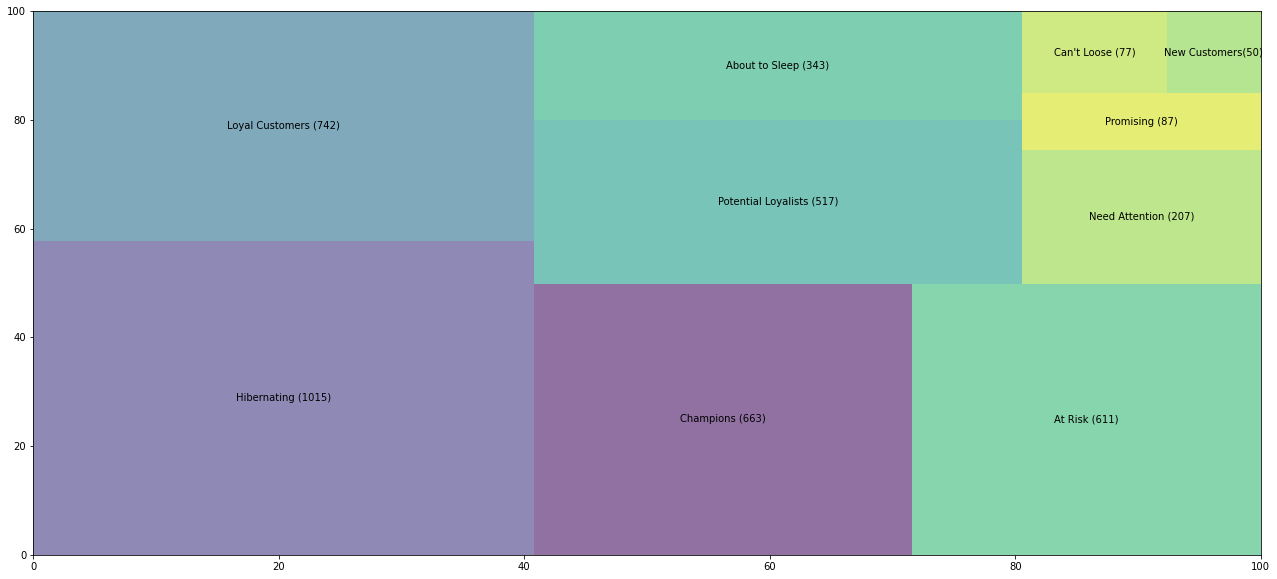

In [80]:
sizes=rfm.sort_values('Segment')['Segment'].value_counts()
label=["Hibernating (1015)","Loyal Customers (742)","Champions (663)","At Risk (611)","Potential Loyalists (517)",
       "About to Sleep (343)","Need Attention (207)","Promising (87)","Can't Loose (77)","New Customers(50)"]
fig, ax = plt.subplots(1, figsize = (22,10))
squarify.plot(sizes=sizes, label=label, alpha=0.6 )

plt.show()

In [77]:
rfm["RFM_SCORE"] = rfm[['recency_score','frequency_score','monetary_score']].sum(axis=1)

In [43]:
# Loyalty levels
loyalty = [ "D", "C", "B", "A"]
rfm['Loyalty_Level'] = pd.qcut(rfm['RFM_SCORE'],4, labels = loyalty)
rfm.head()

recency  frequency  monetary recency_score frequency_score  \
Customer ID                                                               
12346.0          165         11    372.86             2               5   
12347.0            3          2   1323.32             5               2   
12348.0           74          1    222.16             2               1   
12349.0           43          3   2295.02             3               3   
12351.0           11          1    300.93             5               1   

            monetary_score RFM_Combination              Segment  RFM_SCORE  \
Customer ID                                                                  
12346.0                  2             252          Can't Loose          9   
12347.0                  4             524  Potential Loyalists         11   
12348.0                  1             211          Hibernating          4   
12349.0                  5             335       Need Attention         11   
12351.0                  2             512        New Customers          8   

            Loyalty_Level  
Customer ID                
12346.0                 C  
12347.0                 B  
12348.0                 D  
12349.0                 B  
12351.0                 C

In [44]:
rfm.sort_values('Loyalty_Level')['Loyalty_Level'].value_counts()

D    1246
C    1119
B    1022
A     925
Name: Loyalty_Level, dtype: int64

In [45]:
rfm.groupby('Loyalty_Level')[["recency", "frequency", "monetary","RFM_SCORE"]].mean()

recency  frequency     monetary  RFM_SCORE
Loyalty_Level                                               
D              188.626806   1.152488   258.840547   4.662119
C               84.742627   2.079535   662.466114   7.955317
B               47.592955   4.078278  1571.780261  10.953033
A               15.823784  12.196757  6219.891555  14.064865

In [46]:
rfm.groupby('Segment')[["recency", "frequency", "monetary","RFM_SCORE"]].mean()

recency  frequency     monetary  RFM_SCORE
Segment                                                           
About to Sleep        53.819242   1.201166   435.429111   6.481050
At Risk              152.155483   3.073650  1089.292367   8.166939
Can't Loose          124.116883   9.116883  3486.987532  11.207792
Champions              7.119155  12.553544  6570.387425  14.104072
Hibernating          213.884729   1.126108   363.962832   4.568473
Loyal Customers       36.287062   6.830189  2672.967508  12.227763
Need Attention        53.265700   2.449275  1009.158865   9.077295
New Customers          8.580000   1.000000   385.877800   7.800000
Potential Loyalists   18.793037   2.017408   718.512853   9.512573
Promising             25.747126   1.000000   362.921954   6.793103

In [47]:
rfm.head()

recency  frequency  monetary recency_score frequency_score  \
Customer ID                                                               
12346.0          165         11    372.86             2               5   
12347.0            3          2   1323.32             5               2   
12348.0           74          1    222.16             2               1   
12349.0           43          3   2295.02             3               3   
12351.0           11          1    300.93             5               1   

            monetary_score RFM_Combination              Segment  RFM_SCORE  \
Customer ID                                                                  
12346.0                  2             252          Can't Loose          9   
12347.0                  4             524  Potential Loyalists         11   
12348.0                  1             211          Hibernating          4   
12349.0                  5             335       Need Attention         11   
12351.0                  2             512        New Customers          8   

            Loyalty_Level  
Customer ID                
12346.0                 C  
12347.0                 B  
12348.0                 D  
12349.0                 B  
12351.0                 C

In [48]:
cltv_df = df.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (today_date - pd.to_datetime(InvoiceDate).max()).days,
                         lambda InvoiceDate: (today_date - pd.to_datetime(InvoiceDate).min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [49]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

recency    T  frequency  monetary
Customer ID                                   
12346.0          165  361         11    372.86
12347.0            3   40          2   1323.32
12348.0           74   74          1    222.16
12349.0           43  225          3   2295.02
12351.0           11   11          1    300.93

In [50]:
cltv_df.sort_values(by = 'monetary', ascending = False)

recency    T  frequency    monetary
Customer ID                                     
18102.0            1  374         89  313853.375
14646.0           10  373         78  242483.840
14156.0            7  374        102  182758.230
14911.0            1  374        205  143280.610
13694.0            9  371         94  128302.265
...              ...  ...        ...         ...
18115.0          333  333          1       9.700
15040.0          177  177          1       7.490
15913.0          170  170          1       6.300
13788.0          141  141          1       3.750
14095.0          358  358          1       2.950

[4312 rows x 4 columns]

In [51]:
# to calculate the average profit
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [52]:
# to select customers who make us multiple purchases
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [53]:
# BG/NBD model asks us for recency and T weekly
cltv_df["recency"] = cltv_df["recency"] 
cltv_df["T"] = cltv_df["T"] 

In [54]:
cltv_df.sort_values(by = "monetary", ascending = False)

recency    T  frequency     monetary
Customer ID                                      
12357.0           24   24          2  5633.465000
17450.0            3   74          7  5321.585000
14091.0          290  334          2  4584.045000
14088.0           42   57          3  4512.990000
18102.0            1  374         89  3526.442416
...              ...  ...        ...          ...
13666.0           56  371          2    21.625000
17246.0          182  374          2    19.460000
14610.0           31  150          2    12.175000
16454.0          242  247          2    12.025000
18037.0           57  374          9    10.822222

[2893 rows x 4 columns]

In [55]:
# BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 1.68, alpha: 0.34, b: 6.68, r: 0.33>

In [56]:
# Compute the customer alive probability
cltv_df['probability_alive'] = bgf.conditional_probability_alive(cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])
cltv_df.head(10)

recency    T  frequency     monetary  probability_alive
Customer ID                                                         
12346.0          165  361         11    33.896364       1.413090e-03
12347.0            3   40          2   661.660000       1.362759e-02
12349.0           43  225          3   765.006667       2.096443e-02
12352.0           11   28          2   171.900000       3.514577e-01
12356.0           16   60          3  1187.416667       6.264959e-02
12357.0           24   24          2  5633.465000       8.205263e-01
12358.0           11  367          3   901.236667       4.857046e-05
12359.0           61  370          6   422.890000       7.961865e-05
12360.0           15  291          5   313.882000       9.792289e-07
12361.0           98  318          3   107.116667       9.391380e-02

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

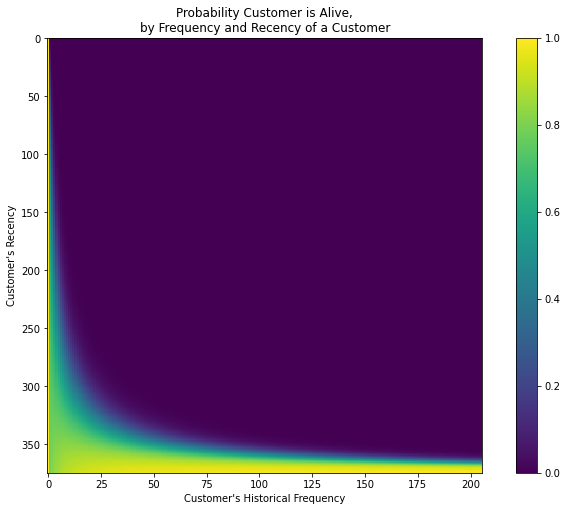

In [57]:
# Visual representation of relationship between recency and frequency
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [58]:
t = 90
cltv_df['pred_num_txn_3_months'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, cltv_df['frequency'], cltv_df['recency'], cltv_df['T']),2)
cltv_df.sort_values(by='pred_num_txn_3_months', ascending=False).head(10).reset_index()

Customer ID  recency   T  frequency  monetary  probability_alive  \
0      17203.0       24  24          4  503.0075           0.852137   
1      15037.0       12  12          2  201.2550           0.820526   
2      15914.0       14  14          2  102.9950           0.820526   
3      17288.0       26  30          4  270.0625           0.757593   
4      17544.0       26  26          3  320.2300           0.837858   
5      17882.0       15  15          2  156.7300           0.820526   
6      16812.0       14  18          3  637.5500           0.694967   
7      18047.0       17  17          2  171.3450           0.820526   
8      17766.0       17  17          2  149.8050           0.820526   
9      17782.0       18  18          2  339.5100           0.820526   

   pred_num_txn_3_months  
0                   6.20  
1                   5.30  
2                   4.96  
3                   4.92  
4                   4.82  
5                   4.80  
6                   4.79  
7                   4.52  
8                   4.52  
9                   4.40

In [59]:
t = 180
cltv_df['pred_num_txn_6_months'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, cltv_df['frequency'], cltv_df['recency'], cltv_df['T']),2)
cltv_df.sort_values(by='pred_num_txn_6_months', ascending=False).head(10).reset_index()

Customer ID  recency   T  frequency  monetary  probability_alive  \
0      17203.0       24  24          4  503.0075           0.852137   
1      15037.0       12  12          2  201.2550           0.820526   
2      17288.0       26  30          4  270.0625           0.757593   
3      17544.0       26  26          3  320.2300           0.837858   
4      15914.0       14  14          2  102.9950           0.820526   
5      17882.0       15  15          2  156.7300           0.820526   
6      16812.0       14  18          3  637.5500           0.694967   
7      18047.0       17  17          2  171.3450           0.820526   
8      17766.0       17  17          2  149.8050           0.820526   
9      17782.0       18  18          2  339.5100           0.820526   

   pred_num_txn_3_months  pred_num_txn_6_months  
0                   6.20                   8.25  
1                   5.30                   6.85  
2                   4.92                   6.77  
3                   4.82                   6.66  
4                   4.96                   6.52  
5                   4.80                   6.38  
6                   4.79                   6.29  
7                   4.52                   6.11  
8                   4.52                   6.11  
9                   4.40                   5.98

In [60]:
t = 365
cltv_df['pred_num_txn_12_months'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, cltv_df['frequency'], cltv_df['recency'], cltv_df['T']),2)
cltv_df.sort_values(by='pred_num_txn_12_months', ascending=False).head(10).reset_index()

Customer ID  recency   T  frequency  monetary  probability_alive  \
0      17203.0       24  24          4  503.0075           0.852137   
1      17288.0       26  30          4  270.0625           0.757593   
2      17544.0       26  26          3  320.2300           0.837858   
3      15037.0       12  12          2  201.2550           0.820526   
4      15914.0       14  14          2  102.9950           0.820526   
5      17882.0       15  15          2  156.7300           0.820526   
6      16812.0       14  18          3  637.5500           0.694967   
7      17766.0       17  17          2  149.8050           0.820526   
8      18047.0       17  17          2  171.3450           0.820526   
9      17782.0       18  18          2  339.5100           0.820526   

   pred_num_txn_3_months  pred_num_txn_6_months  pred_num_txn_12_months  
0                   6.20                   8.25                   10.09  
1                   4.92                   6.77                    8.50  
2                   4.82                   6.66                    8.41  
3                   5.30                   6.85                    8.20  
4                   4.96                   6.52                    7.94  
5                   4.80                   6.38                    7.81  
6                   4.79                   6.29                    7.62  
7                   4.52                   6.11                    7.58  
8                   4.52                   6.11                    7.58  
9                   4.40                   5.98                    7.48

In [61]:
# Checking the relationship between frequency and monetary_value
return_customers_cltv_df = cltv_df[cltv_df['frequency']>0]
print(return_customers_cltv_df.shape)
return_customers_cltv_df.head()

(2893, 8)


recency    T  frequency     monetary  probability_alive  \
Customer ID                                                            
12346.0          165  361         11    33.896364           0.001413   
12347.0            3   40          2   661.660000           0.013628   
12349.0           43  225          3   765.006667           0.020964   
12352.0           11   28          2   171.900000           0.351458   
12356.0           16   60          3  1187.416667           0.062650   

             pred_num_txn_3_months  pred_num_txn_6_months  \
Customer ID                                                 
12346.0                       0.00                   0.01   
12347.0                       0.05                   0.07   
12349.0                       0.02                   0.04   
12352.0                       1.48                   2.14   
12356.0                       0.22                   0.33   

             pred_num_txn_12_months  
Customer ID                          
12346.0                        0.01  
12347.0                        0.10  
12349.0                        0.08  
12352.0                        2.82  
12356.0                        0.47

In [62]:
cltv_df[['frequency', 'monetary']].corr()

frequency  monetary
frequency   1.000000  0.138881
monetary    0.138881  1.000000

In [63]:
# Checking the relationship between frequency and monetary_value
return_customers_cltv_df[['frequency', 'monetary']].corr()

frequency  monetary
frequency   1.000000  0.138881
monetary    0.138881  1.000000

In [64]:
pearsonr(cltv_df["frequency"],cltv_df["monetary"])

(0.13888145462903223, 6.231549030277509e-14)

In [65]:
# GG-model
ggf = GammaGammaFitter(penalizer_coef=0.001) 
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])


<lifetimes.GammaGammaFitter: fitted with 2893 subjects, p: 12.23, q: 0.93, v: 12.14>

In [66]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary'])

In [67]:
cltv_3_months = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=3, # Prediction for 3 months   
                                       freq="D",  # Frequency of T.
                                       discount_rate=0.01)

In [68]:
cltv_6_months = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=6, # Prediction for 6 months   
                                       freq="D",  # Frequency of T.
                                       discount_rate=0.01)

In [69]:
cltv_12_months = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=12, # Prediction for 12 months   
                                       freq="D",  # Frequency of T.
                                       discount_rate=0.01)

In [70]:
cltv.head()

NameError: name 'cltv' is not defined

In [71]:
##cltv_df['calculated_clv'] = cltv_df['pred_num_txn'] * cltv_df['expected_average_profit']

In [72]:
cltv_3_months = cltv_3_months.reset_index()
cltv_final = cltv_df.merge(cltv_3_months, on="Customer ID", how="left")

In [73]:
cltv_6_months = cltv_6_months.reset_index()
cltv_final1 = cltv_final.merge(cltv_6_months, on="Customer ID", how="left")

In [74]:
cltv_12_months = cltv_12_months.reset_index()
cltv_final2 = cltv_final1.merge(cltv_12_months, on="Customer ID", how="left")

In [75]:
cltv_final2.rename (columns= {'clv_x': 'clv_3_months'}, inplace=True)
cltv_final2.rename (columns= {'clv_y': 'clv_6_months'}, inplace=True)
cltv_final2.rename (columns= {'clv': 'clv_12_months'}, inplace=True)

In [80]:
cltv_final2.head()

Customer ID  recency    T  frequency     monetary  probability_alive  \
0      12346.0      165  361         11    33.896364           0.001413   
1      12347.0        3   40          2   661.660000           0.013628   
2      12349.0       43  225          3   765.006667           0.020964   
3      12352.0       11   28          2   171.900000           0.351458   
4      12356.0       16   60          3  1187.416667           0.062650   

   pred_num_txn_3_months  pred_num_txn_6_months  pred_num_txn_12_months  \
0                   0.00                   0.01                    0.01   
1                   0.05                   0.07                    0.10   
2                   0.02                   0.04                    0.08   
3                   1.48                   2.14                    2.82   
4                   0.22                   0.33                    0.47   

   expected_average_profit  clv_3_months  clv_6_months  clv_12_months  
0                35.017824      0.121009      0.214387       0.348813  
1               669.634437     30.121069     45.237551      61.271734  
2               770.514391     18.720268     33.378583      54.962573  
3               178.476380    259.284797    370.961542     480.235487  
4              1193.727495    252.022466    387.948651     536.639261

In [76]:
cltv_final12.groupby('Segment')[["recency", "frequency", "monetary","RFM_SCORE"]].mean()

NameError: name 'cltv_final12' is not defined

In [ ]:
#Scaling CLV Values

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])
cltv_final.sort_values(by="scaled_clv", ascending=False).head(10)

In [82]:
#Segmentation of Scaled CLV Values
cltv_final2["segment_3_month"] = pd.qcut(cltv_final2["clv_3_months"], 4, labels=["D", "C", "B", "A"])
cltv_final2["segment_6_month"] = pd.qcut(cltv_final2["clv_6_months"], 4, labels=["D", "C", "B", "A"])
cltv_final2["segment_12_month"] = pd.qcut(cltv_final2["clv_12_months"], 4, labels=["D", "C", "B", "A"])
cltv_final2.head()

Customer ID  recency    T  frequency     monetary  probability_alive  \
0      12346.0      165  361         11    33.896364           0.001413   
1      12347.0        3   40          2   661.660000           0.013628   
2      12349.0       43  225          3   765.006667           0.020964   
3      12352.0       11   28          2   171.900000           0.351458   
4      12356.0       16   60          3  1187.416667           0.062650   

   pred_num_txn_3_months  pred_num_txn_6_months  pred_num_txn_12_months  \
0                   0.00                   0.01                    0.01   
1                   0.05                   0.07                    0.10   
2                   0.02                   0.04                    0.08   
3                   1.48                   2.14                    2.82   
4                   0.22                   0.33                    0.47   

   expected_average_profit  clv_3_months  clv_6_months  clv_12_months  \
0                35.017824      0.121009      0.214387       0.348813   
1               669.634437     30.121069     45.237551      61.271734   
2               770.514391     18.720268     33.378583      54.962573   
3               178.476380    259.284797    370.961542     480.235487   
4              1193.727495    252.022466    387.948651     536.639261   

  segment_3_month segment_6_month segment_12_month  
0               C               C                C  
1               B               B                B  
2               B               B                B  
3               A               A                A  
4               A               A                A

In [91]:
cltv_final2.rename (columns= {'segment_3_month': 'Loyalty_Level'}, inplace=True)

In [94]:
seg = cltv_final2.groupby('segment_6_month')[["clv_3_months","clv_6_months","clv_12_months"]].mean()

In [95]:
seg.to_excel('seg_cltv.xlsx')

In [ ]:
cltv_final2.sort_values('segment_3_month')['segment_3_month'].value_counts()

In [ ]:
cltv_final2.sort_values('segment_6_month')['segment_6_month'].value_counts()

In [ ]:
cltv_final2.sort_values('segment_12_month')['segment_12_month'].value_counts()

In [ ]:
cltv_final2.to_excel('CLTV_final_final.xlsx')

In [ ]:
rfm.to_excel('RFM_final.xlsx')

In [ ]:
cltv_final.sort_values('segment')['segment'].value_counts()

In [84]:
df=('Loyalty level':['D','C','B','A'],'Count':[1078,1078,1078,1078])

SyntaxError: invalid syntax (<ipython-input-84-2d4087ab4519>, line 1)

In [83]:
pd.dataframe(df)

AttributeError: module 'pandas' has no attribute 'dataframe'

In [85]:
data=[[‘Karan’,23],[‘Rohit’,22],[‘Sahil’,21],[‘Aryan’,24]]

df=pd.dataframe(data,columns=[‘Name’,’Age’])

df

SyntaxError: invalid character in identifier (<ipython-input-85-387b792948b9>, line 1)

In [87]:
import pandas as pd
data = {'Loyalty Level':["D","C","B","A"],'Count':['1078','1078','1078','1078']}
data_=pd.DataFrame(data)
data_

Loyalty Level Count
0             D  1078
1             C  1078
2             B  1078
3             A  1078